# **Imports**

In [ ]:
# If using google colab
# Run the following codes

# Mount google drive
#from google.colab import drive
#drive.mount('/content/drive')
#!pip install -r "/content/drive/MyDrive/~/requirements.txt" # Replace with the path to your requirements.txt file
#from google.colab.patches import cv2_imshow 
#from google.colab import drive

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import sklearn.metrics
import tensorflow as tf

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from collections import Counter
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, UpSampling2D, Input
from keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# **Helper functions**

In [2]:
# Import function

def import_database(dir):

  with open(dir, "rb") as file:
    data = []
    for i in range(0, 2):
       #with open(dir, "rb") as file:
        data.append(pickle.load(file))

  return data[0], data[1]

def onehot(y):

  y_onehot = []

  for i in y.to_numpy():
    if i == 1: y_onehot.append([0, 1])
    else: y_onehot.append([1, 0])

  y_onehot = np.array(y_onehot)

  return y_onehot

def myconfusion_matrix(y_true, y_pred):
  tp, tn, fp, fn = 0, 0, 0, 0

  for i in range(0, len(y_true)):
    if y_pred[i] == y_true[i]:
      if y_pred[i] == 0:
        tn = tn + 1
      else:
        tp = tp + 1
    else:
      if y_pred[i] == 0:
        fn = fn + 1
      else:
        fp = fp + 1

  return tp, tn, fp, fn

# Calculates the metrics: accuracy, recall, precision, f1_score, and specificity
def myaccuracy(y_true, y_pred):
    tp, tn, fp, fn = myconfusion_matrix(y_true, y_pred)
    if (tp + tn + fp + fn) == 0: return 0
    return (tp + tn) / (tp + tn + fp + fn)

def myrecall(y_true, y_pred):
    tp, tn, fp, fn = myconfusion_matrix(y_true, y_pred)
    if (tp + fn) == 0: return 0
    return tp / (tp + fn)

def myprecision(y_true, y_pred):
    tp, tn, fp, fn = myconfusion_matrix(y_true, y_pred)
    if (tp + fp) == 0: return 0
    return tp / (tp + fp)

def myf1_score(y_true, y_pred):
    tp, tn, fp, fn = myconfusion_matrix(y_true, y_pred)
    denom = (myprecision(y_true, y_pred) + myrecall(y_true, y_pred))
    if denom == 0: return 0
    return 2 * (myprecision(y_true, y_pred) * myrecall(y_true, y_pred)) / denom

def myspecificity(y_true, y_pred):
    tp, tn, fp, fn = myconfusion_matrix(y_true, y_pred)
    if (tn + fp) == 0: return 0
    return tn / (tn + fp)

# **Classifying Congential Syphilis**

## Import data set

In [35]:
dir = 'datasets/imaegs/Syphilis_tsne_34x34.pkl'

X_train, X_test = import_database(dir)

y_train = pd.read_csv('datasets/labels/y_train.csv', sep=';')
y_test = pd.read_csv('datasets/labels/y_test.csv', sep=';')

enc = sklearn.preprocessing.OneHotEncoder(categories='auto', sparse_output=False)

y_train = enc.fit_transform(y_train)
y_test = enc.transform(y_test)

In [36]:
# Transforming in grayscale

X_train = tf.image.rgb_to_grayscale(X_train)
X_test = tf.image.rgb_to_grayscale(X_test)

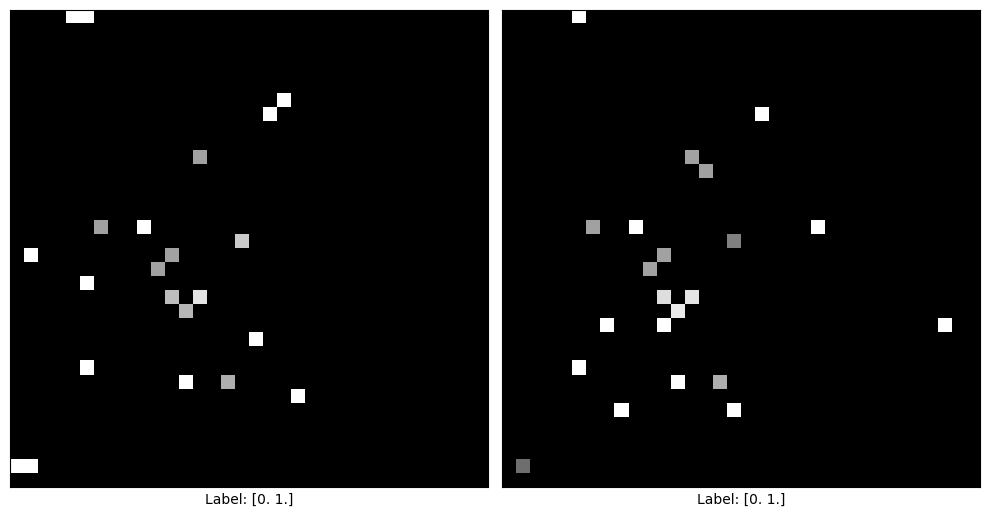

In [37]:
c = 2

fig, ax = plt.subplots(1, c, figsize=(10, 10))

for i in range(0, c):
    ax[i].imshow(X_train[i], cmap='gray')
    ax[i].set_xlabel("Label: {}".format(y_train[i]))
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()

In [38]:
shapes = pd.DataFrame(
    {

      "Train": [X_train.shape, y_train.shape],
      "Test": [X_test.shape, y_test.shape],
    }, index=['x', 'y']
)

shapes

,Train,Test
x,"(1321, 34, 34, 1)","(331, 34, 34, 1)"
y,"(1321, 2)","(331, 2)"


In [39]:
print(Counter(np.argmax(y_train, axis=1)))
print(Counter(np.argmax(y_test, axis=1)))

Counter({np.int64(1): 661, np.int64(0): 660})
Counter({np.int64(0): 166, np.int64(1): 165})


## Basic CNN - Congenital Syphilis


In [42]:
# Set up and train model up to 200 to get the epoch with the best validation accuracy
basic_model = Sequential([
                    Input(X_train[0].shape),
                    Conv2D(32, 3, 1, padding="same", activation="relu", data_format='channels_last'),
                    MaxPooling2D(pool_size=2, strides=1, padding="same"),
                    Flatten(),
                    Dense(2, activation="sigmoid")
                    ])

basic_model.compile(
    optimizer="Adam",
    loss="binary_crossentropy",
    metrics=["binary_accuracy"]
)

basic_history = basic_model.fit(
                      X_train,
                      y_train,
                      batch_size=256,
                      epochs=200,
                      shuffle=True,
                      validation_split=0.1,
                      verbose=0,
                  )

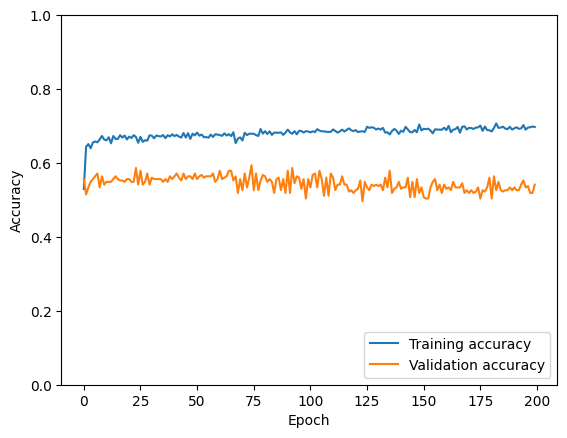

In [43]:
# Plot training graph
plt.plot(basic_history.history['binary_accuracy'], label = 'Training accuracy')
plt.plot(basic_history.history['val_binary_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

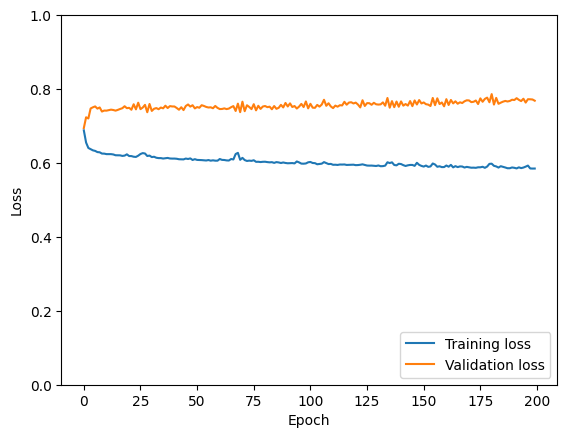

In [44]:
# Plot loss
plt.plot(basic_history.history['loss'], label = 'Training loss')
plt.plot(basic_history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [45]:
### GET BEST EPOCHS ###

val_acc_per_epoch = basic_history.history['val_binary_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('\nBest epoch: %d' % (best_epoch))


Best epoch: 75


In [ ]:
# Train and test 30 times to get the average of the metrics

mydados_relatorio_modelo = []

header_dados_relatorio_modelo = ['acc', 'recall', 'precision', 'f1_score', 'specificity']

y_true = [np.argmax(x) for x in y_test]

for exp in range(0, 30):

    basic_model.fit(X_train, y_train, epochs=best_epoch, verbose=0)

    y_pred = basic_model.predict(X_test)
    y_pred = [np.argmax(x) for x in y_pred]

    # Based on my confusion matrix
    tp, tn, fp, fn = myconfusion_matrix(y_true, y_pred)

    my_accuracy = accuracy_score(y_true, y_pred)
    my_recall = recall_score(y_true, y_pred, average='binary', pos_label=0)
    my_precision = precision_score(y_true, y_pred, average='binary', pos_label=0)
    my_f1_score = f1_score(y_true, y_pred, average='binary', pos_label=0)
    my_specificity = tp / (tp + fn)

    # My confusionmatrix
    mydados_relatorio_modelo.append([my_accuracy, my_recall, my_precision, my_f1_score, my_specificity])

# Saving metrics in a datframe
mydados_relatorio_modelo_df = pd.DataFrame(mydados_relatorio_modelo, columns=header_dados_relatorio_modelo)

In [ ]:
final_report = pd.DataFrame(mydados_relatorio_modelo_df.mean(axis=0))

In [ ]:
final_report

,0
acc,0.553877
recall,0.535341
precision,0.557114
f1_score,0.543166
specificity,0.572525


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


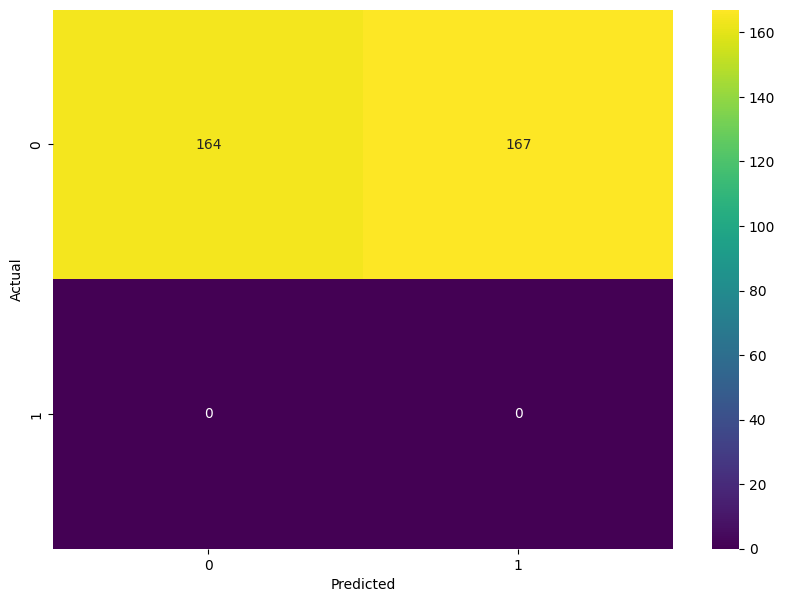

In [65]:
# Fit the model with the best epoch and test it to get confusion matrix and misclassified images

#basic_model.fit(X_train, y_train, epochs=best_epoch, verbose=0)

y_pred = basic_model.predict(X_test)
y_pred = [np.argmax(x) for x in y_pred]
y_test = [np.argmax(x) for x in y_test]

# Based on my confusion matrix
tp, tn, fp, fn = myconfusion_matrix(y_test, y_pred)

# My confusion matrix
my_confusion_matrix = pd.DataFrame(
    {
        "Negative": [tp, fp],
        "Positive": [fn, tn]
    }, index=["Negative", "Positive"]
)

cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Saving results

In [ ]:
# Save results

report_dir = 'results/Deepinsight_basic_cong_syphilis_report.csv'
final_dir = 'results/Deepinsight_basic_cong_syphilis_mean.csv'

mydados_relatorio_modelo_df.to_csv(report_dir, sep=';')
final_report.to_csv(final_dir, sep=';')

# Save model

dir = 'models/Deepinsight_basic_cong_syphilis.pkl'

with open(dir, 'wb') as file:
  pickle.dump(basic_model, file)